# Assignment 2: Stochastic & Spatial SIR Models

Lisa Pahladsingh & Sanhjana Bhusal

## Problem 1: Gillespie’s Direct Algorithm and Stochastic Hallmarks

### 1.1 Implement Gillespies algorithm

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
from scipy.integrate import odeint

random.seed(0) # ensures same randomness

The sum of the rates (at a time t) define the proportions of the rates in a specific population dynamic of the system. Therefore, if the proportion of infected is very high the recovery rate will make up a higher part of the sum of the rates. Thus, the I->R event is much more likely to happen.

In [2]:
#Defining all necessary functions

# SIR with gillespies algo
def SIR_GA(S_0, I_0, R_0, t_0, t_end, beta, gamma, mu):
    S = [S_0]
    I = [I_0]
    R = [R_0]
    t = [t_0]

# Create a while loop
    while t[-1] < t_end and (S[-1] + I[-1] >= 1):
        
        N = S[-1] + I[-1] + R[-1]
        rates = [mu * N, beta * I[-1] * S[-1]/N, gamma * I[-1], mu * S[-1], mu * I[-1], mu * R[-1]]
        rates_sum = sum(rates)

        if rates_sum != 0:
            tau = np.random.exponential(scale = 1/rates_sum) 

        else:
            tau = 0  

        rand_num = random.uniform(0, 1)

        # Birth
        if rand_num * rates_sum <= rates[0]:
            S.append(S[-1] + 1)
            I.append(I[-1])
            R.append(R[-1])

        # S -> I
        elif rand_num * rates_sum > rates[0] and rand_num * rates_sum <= sum(rates[:2]):
            S.append(S[-1] - 1)
            I.append(I[-1] + 1)
            R.append(R[-1])

        # I -> R
        elif rand_num * rates_sum > sum(rates[:2]) and rand_num * rates_sum <= sum(rates[:3]):
            S.append(S[-1])
            I.append(I[-1] - 1)
            R.append(R[-1] + 1)

        # S -> death
        elif rand_num * rates_sum > sum(rates[:3]) and rand_num * rates_sum <= sum(rates[:4]): 
            S.append(S[-1] - 1)
            I.append(I[-1])
            R.append(R[-1])

        # I -> death
        elif rand_num * rates_sum > sum(rates[:4]) and rand_num * rates_sum <= sum(rates[:5]): 
            S.append(S[-1])
            I.append(I[-1] - 1)
            R.append(R[-1])

        # R -> death
        elif rand_num * rates_sum > sum(rates[:5]) and rand_num * rates_sum <= sum(rates[:6]): 
            S.append(S[-1])
            I.append(I[-1])
            R.append(R[-1] - 1)

        t.append(t[-1] + tau)
    
    return(t, S, I, R)

# Define SIR model with demography
def SIR_dem(y, t, beta, gamma, mu):
    S = y[0]
    I = y[1]
    R = y[2]
    
    dSdt = mu - beta * S * I - mu * S
    dIdt = beta * S * I - gamma * I - mu * I
    dRdt = gamma * I - mu * R
    
    return [dSdt, dIdt, dRdt]

### Plotting Gillespies for a single run

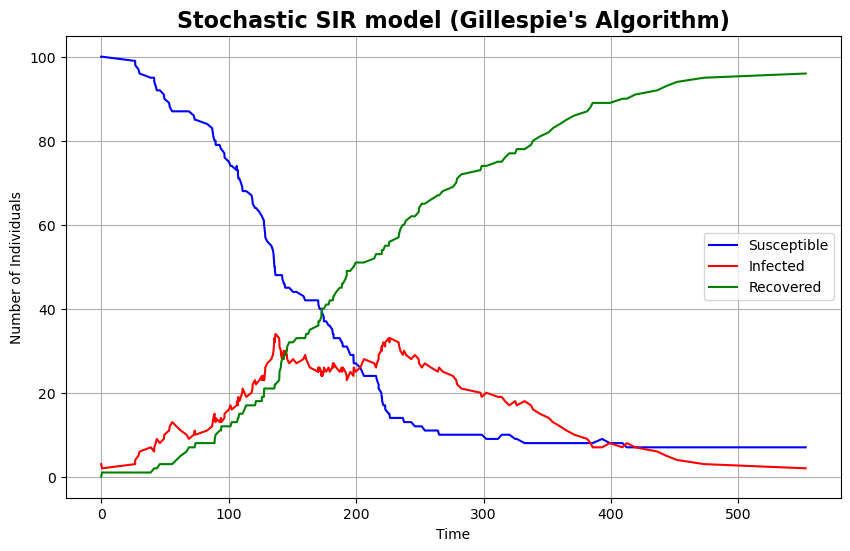

In [3]:
# Define initial value lists
S_0 = 100
I_0 = 3
R_0 = 0

t_0 = 0
t_end = 500

beta = 0.04
gamma = 0.01
mu = 0.02 / 365

t, S, I, R = SIR_GA(S_0, I_0, R_0, t_0, t_end, beta, gamma, mu)

# Plotting
plt.figure(figsize=(10,6))
plt.plot(t, S, label='Susceptible', color='blue')
plt.plot(t, I, label='Infected', color='red')
plt.plot(t, R, label='Recovered', color='green')
plt.xlabel('Time')
plt.ylabel('Number of Individuals')
plt.title("Stochastic SIR model (Gillespie's Algorithm)", fontsize=16, fontweight='bold')
plt.legend()
plt.grid(True)
plt.show()

### Gillespies averaged over a number of runs

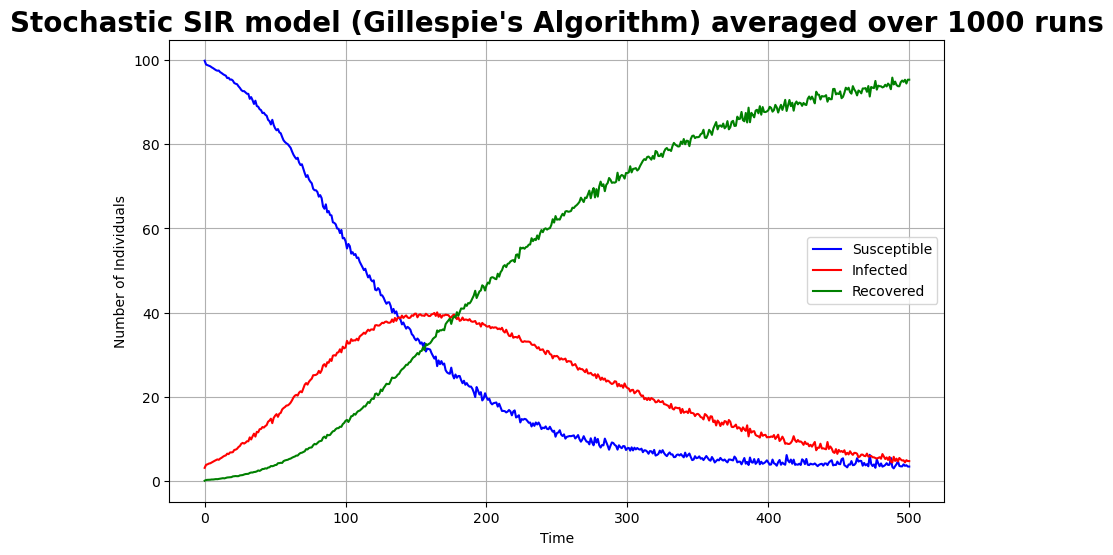

In [20]:
# Setting up function for averaging
def GA_average(S_0, I_0, R_0, t_0, t_end, beta, gamma, mu, n_sim):

    # Setting data range
    t_data = np.linspace(0, t_end, t_end+1)
    S_data = np.empty((t_end+1, 0)).tolist()
    I_data = np.empty((t_end+1, 0)).tolist() 
    R_data = np.empty((t_end+1, 0)).tolist()

    for _ in range(n_sim):
        t, S, I, R = SIR_GA(S_0, I_0, R_0, t_0, t_end, beta, gamma, mu)
        for i, time in enumerate(t):
            # Add S, I, R values from GA to predefined list
            if time < t_end:
                S_data[int(time)].append(S[i])
                I_data[int(time)].append(I[i])
                R_data[int(time)].append(R[i])

    # Average values
    for i in range(len(t_data)):
        if len(S_data[i]) == 0:
            S_data[i] = S_data[i-1]
            I_data[i] = I_data[i-1]
            R_data[i] = R_data[i-1]
        else:
            S_data[i] = sum(S_data[i])/len(S_data[i])
            I_data[i] = sum(I_data[i])/len(I_data[i])
            R_data[i] = sum(R_data[i])/len(R_data[i])
            
    return t_data, S_data, I_data, R_data

# Define initial value lists
S_0 = 100
I_0 = 3
R_0 = 0

t_0 = 0
t_end = 500

beta = 0.04
gamma = 0.01
mu = 0.02 / 365

# Average number of runs
n_sim = 1000

t_data, S_data, I_data, R_data = GA_average(S_0, I_0, R_0, t_0, t_end, beta, gamma, mu, n_sim)

# Plotting
plt.figure(figsize=(10,6))
plt.plot(t_data, S_data, label='Susceptible', color='blue')
plt.plot(t_data, I_data, label='Infected', color='red')
plt.plot(t_data, R_data, label='Recovered', color='green')
plt.xlabel('Time')
plt.ylabel('Number of Individuals')
plt.title(f"Stochastic SIR model (Gillespie's Algorithm) averaged over {n_sim} runs", fontsize=20, fontweight='bold')
plt.legend()
plt.grid(True)
plt.show()

### 1.2: Comparing variance anc covariance between runs

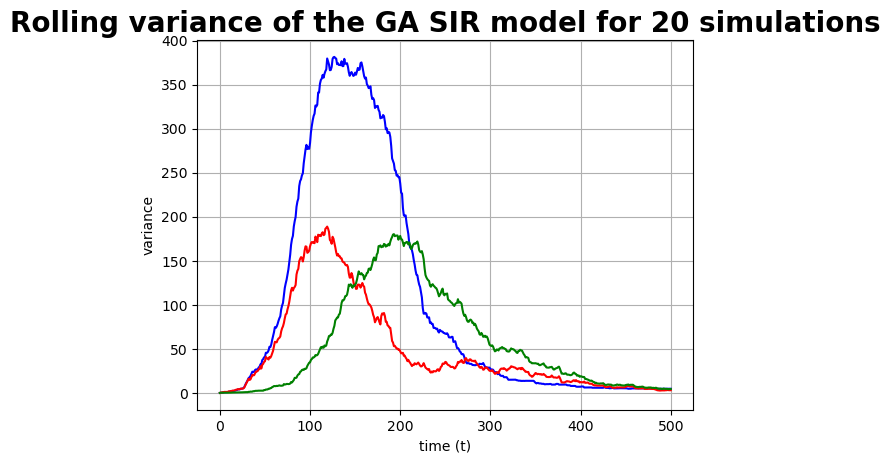

In [23]:
# Setting up function for variance
def GA_var(S_0, I_0, R_0, t_0, t_end, beta, gamma, mu, n_run):

    # Setting range for binning of values
    t_data = np.linspace(0, t_end, t_end+1)
    
    # Setting data range
    S_df = pd.DataFrame(index=t_data)
    I_df = pd.DataFrame(index=t_data) 
    R_df = pd.DataFrame(index=t_data)
    
    for i_run in range(n_run):
        
        # Setting empty list of bins
        S_data = np.empty((t_end+1, 0)).tolist()
        I_data = np.empty((t_end+1, 0)).tolist() 
        R_data = np.empty((t_end+1, 0)).tolist()
        
        # Getting data
        t, S, I, R = SIR_GA(S_0, I_0, R_0, t_0, t_end, beta, gamma, mu)

        for i, time in enumerate(t):
            if time < t_end:
                S_data[int(time)].append(S[i])
                I_data[int(time)].append(I[i])
                R_data[int(time)].append(R[i])

        for i in range(len(t_data)):
            if len(S_data[i]) == 0:
                S_data[i] = S_data[i-1]
                I_data[i] = I_data[i-1]
                R_data[i] = R_data[i-1]
            else:
                S_data[i] = sum(S_data[i])/len(S_data[i])
                I_data[i] = sum(I_data[i])/len(I_data[i])
                R_data[i] = sum(R_data[i])/len(R_data[i])
        
        # Adding to df
        S_df[str(i_run)] = S_data
        I_df[str(i_run)] = I_data
        R_df[str(i_run)] = R_data
      
    
    S_df_var = S_df.var(axis=1, ddof=0)
    I_df_var = I_df.var(axis=1, ddof=0)
    R_df_var = R_df.var(axis=1, ddof=0)
        
    return S_df_var, I_df_var, R_df_var

# Define initial value lists
S_0 = 100
I_0 = 3
R_0 = 0

t_0 = 0
t_end = 500

beta = 0.04
gamma = 0.01
mu = 0.02 / 365

# Average number of runs
n_run = 20

S_var, I_var, R_var = GA_var(S_0, I_0, R_0, t_0, t_end, beta, gamma, mu, n_run)
S_var.plot(label="var Susceptibles", color='blue')
I_var.plot(label="var Infected", color='red')
R_var.plot(label="var Recovered", color='green')
plt.xlabel("time (t)")
plt.ylabel("variance")
plt.title(f"Rolling variance of the GA SIR model for {n_test} simulations", fontsize=20, fontweight='bold')
plt.grid(True)
plt.show()